# MSBD 5001 Individual Project (Kaggle)

## Import Library

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

In [4]:
import statsmodels.api as sm 

In [5]:
SEED = None

## Load Dataset and Make Features

In [6]:
df_raw = pd.read_csv('train.csv', index_col='id')

In [7]:
df_raw.head()

,penalty,l1_ratio,alpha,max_iter,random_state,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,time
id,,,,,,,,,,,,,,
0,none,0.304083,0.0001,417,475,-1,1089,327,4,3,7,0.074798,24.242009,0.409987
1,l1,0.727744,0.0010,578,569,1,790,373,4,5,7,0.077781,54.626302,3.950953
2,none,0.745885,0.0100,588,529,2,428,1198,2,5,6,0.030196,17.999964,0.368702
3,none,0.474605,0.0010,829,103,4,877,313,6,5,7,0.057261,82.257222,1.004559
4,elasticnet,0.395049,0.0010,167,418,2,216,644,8,5,11,0.073728,95.515601,0.802800


Feature engineering:
1. if n_jobs = -1, change to 16
2. if n_classes = 2, change to 1
3. Create a new feature, x = log(max_iter * n_samples * n_features * n_classes / (1 + n_jobs))
4. Group n_jobs into (1, 2, and 2+)
5. Group penalty into ('elasticnet', 'l1' and 'l2 or none')

In [8]:
# Create Features
def make_feature(df_input):
    df = df_input.copy()
    
    #df['y'] = np.log(df['time'])
    
    df['n_jobs'] = np.where(df['n_jobs'] == -1, 16, df['n_jobs'])
    df['n_jobs_1'] = (df['n_jobs'] == 1) * 1
    df['n_jobs_2'] = (df['n_jobs'] == 2) * 1
    df['n_jobs_2+'] = (~df['n_jobs'].isin([1, 2])) * 1
        
    df['penalty_en'] = (df['penalty'] == 'elasticnet') * 1
    df['penalty_l1'] = (df['penalty'] == 'l1') * 1
    df['penalty_l2_none'] = (df['penalty'].isin(['l2', 'none'])) * 1
    
    df['n_classes'] = np.where(df['n_classes'] == 2, 1, df['n_classes'])
    
    df['x'] = np.log(df.max_iter * df.n_samples * df.n_features * df.n_classes / (1 + df.n_jobs))
    
    df['n_jobs'] = np.where(~df['n_jobs'].isin([1, 2]), '2+', df['n_jobs'])
    df['penalty'] = np.where(df['penalty'].isin(['l2', 'none']), 'l2 or none', df['penalty'])
    
    return df

In [9]:
df = make_feature(df_raw)

In [10]:
# Fit on y = log(time)
df['y'] = np.log(df['time'])

In [11]:
X_var = ['x', 'n_jobs', 'penalty'] 
to_keep = X_var + ['y']

In [12]:
df = df[to_keep]

In [13]:
df.head(10)

,x,n_jobs,penalty,y
id,,,,
0,17.369143,2+,l2 or none,-0.891629
1,19.646332,1,l1,1.373957
2,18.425647,2,l2 or none,-0.997767
3,19.425252,2+,l2 or none,0.004549
4,17.941800,2,elasticnet,-0.219649
5,20.669974,2+,l1,2.068900
6,20.694319,2,l2 or none,0.791209
7,19.165264,2+,l1,0.878440
8,16.826024,2+,l1,0.002338


## Weighted Linear Regression (Degree = 1 & 2)

In [14]:
# Helper function: Print MSE
def print_lin_reg_score(df):
    mse = mean_squared_error(np.exp(df.y), np.exp(df.y_pred))
    print(mse)

Fit weighted linear regression by groups (n_jobs and penalty):
1. $y = a + bx$ 
2. $y = a + bx + cx^2$

In [15]:
# WLS Degree 1
def lin_reg_d1(df, X_var, y_var):
    X = df[X_var]
    y = df[y_var]
    
    # Weighted by normalized X
    w = np.exp(scale(np.array(X)))
    #w = 1.0
    X = sm.add_constant(X)
    ols = sm.WLS(y, X, weights=w).fit()
    return ols.params

In [16]:
# WLS Degree 2
def lin_reg_d2(df, X_var, y_var):
    X = df[X_var]
    y = df[y_var]
    
    # Weighted by normalized X
    w = np.exp(scale(np.array(X)))
    #w = 1.0
    X = np.column_stack((X, X**2))
    X = sm.add_constant(X)
    ols = sm.WLS(y, X, weights=w).fit()
    return ols.params

In [17]:
# Fit regression by 'n_jobs' & 'penalty'
def lin_reg(df_input):
    df = df_input.copy()
    
    ols_d1 = df.groupby(['n_jobs', 'penalty']).apply(lin_reg_d1, ['x'], 'y')
    ols_d2 = df.groupby(['n_jobs', 'penalty']).apply(lin_reg_d2, ['x'], 'y')

    params_d1 = ols_d1.reset_index()
    params_d1.rename({'const':'const_d1', 'x':'x_d1'}, axis=1, inplace=True)

    params_d2 = ols_d2.reset_index()
    params_d2.rename({'const':'const_d2', 'x1':'x1_d2', 'x2':'x2_d2'}, axis=1, inplace=True)
    
    return params_d1, params_d2

In [18]:
# For prediction
def lin_reg_predict(df_input, params_d1, params_d2):
    df = df_input.copy()
    
    df = df.merge(params_d1, how='left', on=['n_jobs', 'penalty'])
    df = df.merge(params_d2, how='left', on=['n_jobs', 'penalty'])

    # Linear regression for n_jobs = 1 or 2 and penalty = 'elasticnet' or 'l1'
    # Polynomial regression for other groups
    
    # df['y_pred'] = np.where((df['n_jobs'].isin(['1', '2'])) & (df['penalty'].isin(['elasticnet', 'l1'])),
    #                          df.const_d1 + df.x_d1 * df.x,
    #                          df.const_d2 + df.x1_d2 * df.x + df.x2_d2 * df.x ** 2)


    # All polynomial regression
    df['y_pred'] = df.const_d2 + df.x1_d2 * df.x + df.x2_d2 * df.x ** 2
        
    return df

In [19]:
params_d1, params_d2 = lin_reg(df)

In [20]:
params_d1

,n_jobs,penalty,const_d1,x_d1
0,1,elasticnet,-18.249784,1.007684
1,1,l1,-17.444053,0.959466
2,1,l2 or none,-19.222725,0.974102
3,2,elasticnet,-15.922911,0.886898
4,2,l1,-17.186027,0.940550
5,2,l2 or none,-16.292386,0.824489
6,2+,elasticnet,-11.874354,0.680618
7,2+,l1,-12.743758,0.717702
8,2+,l2 or none,-14.186580,0.718770


In [21]:
params_d2

,n_jobs,penalty,const_d2,x1_d2,x2_d2
0,1,elasticnet,-22.357972,1.407820,-0.009731
1,1,l1,-13.026999,0.528279,0.010500
2,1,l2 or none,-22.137617,1.255908,-0.006795
3,2,elasticnet,-19.204594,1.212989,-0.008081
4,2,l1,-22.996703,1.506729,-0.013746
5,2,l2 or none,4.997808,-1.319290,0.053807
6,2+,elasticnet,11.695806,-1.808622,0.065560
7,2+,l1,6.993846,-1.373429,0.055173
8,2+,l2 or none,7.215817,-1.498494,0.057220


In [22]:
df_pred = lin_reg_predict(df, params_d1, params_d2)

In [23]:
df_pred.sort_values('y', ascending=False).head(10)

,x,n_jobs,penalty,y,const_d1,x_d1,const_d2,x1_d2,x2_d2,y_pred
214,22.034792,1,l1,3.716007,-17.444053,0.959466,-13.026999,0.528279,0.010500,3.711592
336,22.189659,2,l1,3.649952,-17.186027,0.940550,-22.996703,1.506729,-0.013746,3.668828
178,21.597349,1,elasticnet,3.510065,-18.249784,1.007684,-22.357972,1.407820,-0.009731,3.508463
320,21.702240,1,l1,3.399985,-17.444053,0.959466,-13.026999,0.528279,0.010500,3.383191
224,21.769721,2,elasticnet,3.386061,-15.922911,0.886898,-19.204594,1.212989,-0.008081,3.372161
48,21.324179,1,elasticnet,3.226297,-18.249784,1.007684,-22.357972,1.407820,-0.009731,3.237977
233,21.279314,1,elasticnet,3.205231,-18.249784,1.007684,-22.357972,1.407820,-0.009731,3.193415
126,21.197027,1,elasticnet,3.105551,-18.249784,1.007684,-22.357972,1.407820,-0.009731,3.111580
38,21.495974,2,l1,3.097189,-17.186027,0.940550,-22.996703,1.506729,-0.013746,3.040193
381,21.290524,1,l1,2.959878,-17.444053,0.959466,-13.026999,0.528279,0.010500,2.979832


In [24]:
# Training error. No reference value
print_lin_reg_score(df_pred)

0.37512233397591677


## Prepare Submission File

In [25]:
df_test = pd.read_csv('test.csv', index_col='id')

In [26]:
df_test = make_feature(df_test)

In [27]:
df_test = df_test[X_var]

In [28]:
df_pred = lin_reg_predict(df_test, params_d1, params_d2)

In [29]:
df_pred['Time'] = np.exp(df_pred['y_pred'])

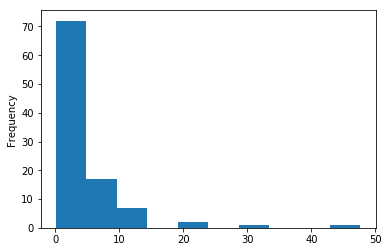

In [30]:
df_pred.Time.plot(kind='hist'); plt.show()

In [31]:
import datetime
GEN_DATE = datetime.datetime.today().strftime('%Y-%m-%d')
df_pred = pd.DataFrame(df_pred, columns={'Time'})
df_pred.index.name = 'Id'
df_pred.to_csv(GEN_DATE+'_predict.csv')

## END